Load the necessary libraries and datasets



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import linprog, minimize

# Load the datasets
boiler_input_df = pd.read_csv('boilerinput.csv')
coal_df = pd.read_csv('coaldf.csv')
boiler_output_df = pd.read_csv('boileroutput.csv')


Merge datasets and preprocess data

In [2]:
# Merge datasets
merged_df = pd.merge(boiler_input_df, coal_df, on="time", how="inner")
merged_df = pd.merge(merged_df, boiler_output_df, on="time", how="inner")

# Drop rows with missing values for boiler efficiency
data = merged_df.dropna(subset=['Boiler Efficiency'])

# Define features and target variable
X = data[['Main Steam Flow', 'PRIMARY AIR FLOW', 'Sulphur in Fuel', 'Moisture in Fuel', 
          'Hydrogen In Fuel', 'GCV', 'SECOND AIR FLOW TOTAL']]
y = data['Boiler Efficiency']


Train a machine learning model to predict boiler efficiency (Linear Regression)

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict the boiler efficiency on the test set
y_pred = linear_model.predict(X_test)

# Calculate the model's performance (mean squared error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Linear Regression): {mse}')


Mean Squared Error (Linear Regression): 0.6745566867037759


Linear Optimization (Minimize cost while maximizing efficiency)

In [4]:
# Linear Optimization: Define the objective and constraints
# Objective: Minimize cost (simplified version)
cost_per_unit_coal = 1  # Example: cost per unit of coal
cost_per_unit_air = 0.5  # Example: cost per unit of air

# Coefficients for the cost function (coal flow and air flow)
c = [cost_per_unit_coal, cost_per_unit_air]

# Constraints (e.g., boiler efficiency should be above 80%)
# In this case, we assume linear approximation from the model for simplicity
A = [[-linear_model.coef_[0], -linear_model.coef_[1]]]  # Constraints for efficiency
b = [-80]  # We want the efficiency to be at least 80%

# Bounds for coal and air flow (example ranges)
x0_bounds = (0, 1000)  # Bounds for coal flow
x1_bounds = (0, 1000)  # Bounds for air flow

# Linear programming optimization
result = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds], method='simplex')

# Optimal coal and air flow
optimal_coal_flow, optimal_air_flow = result.x
print(f"Optimized Coal Flow: {optimal_coal_flow}")
print(f"Optimized Air Flow: {optimal_air_flow}")


Optimized Coal Flow: 1000.0
Optimized Air Flow: 0.0


C:\Users\mindf\AppData\Local\Temp\ipykernel_31728\364750913.py:19: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  result = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds], method='simplex')


Non-Linear Optimization (Using Support Vector Regression)

In [5]:
# Train a Support Vector Regression (SVR) model
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict the boiler efficiency on the test set
y_pred_svr = svr_model.predict(X_test)

# Calculate the model's performance
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f'Mean Squared Error (SVR): {mse_svr}')

# Non-linear Optimization: Using SVR model to predict efficiency and optimize parameters
def svr_objective(params):
    coal_flow, air_flow = params
    prediction = svr_model.predict([[coal_flow, air_flow, 0, 0, 0, 0, 0]])  # Simplified input
    return abs(prediction - 80)  # Minimize difference from target efficiency (80%)

# Perform non-linear optimization
result_nl = minimize(svr_objective, [500, 500], bounds=[(0, 1000), (0, 1000)])
optimal_coal_flow_nl, optimal_air_flow_nl = result_nl.x
print(f"Optimized Coal Flow (Non-Linear): {optimal_coal_flow_nl}")
print(f"Optimized Air Flow (Non-Linear): {optimal_air_flow_nl}")


Mean Squared Error (SVR): 1.3325903788761555
Optimized Coal Flow (Non-Linear): 1000.0
Optimized Air Flow (Non-Linear): 1000.0


c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\mindf\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  w

Visualize the results


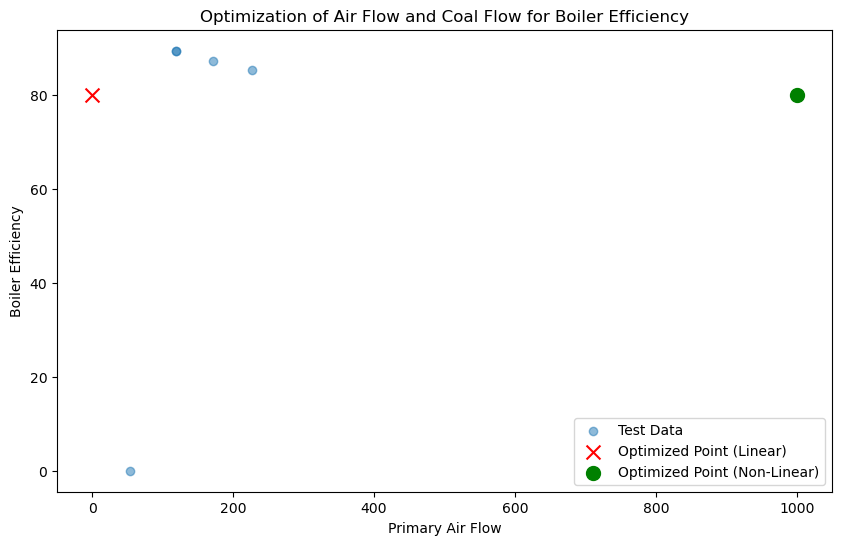

In [6]:
# Plotting the original data and optimized points
plt.figure(figsize=(10, 6))
plt.scatter(X_test['PRIMARY AIR FLOW'], y_test, label='Test Data', alpha=0.5)
plt.scatter(optimal_air_flow, 80, color='red', label='Optimized Point (Linear)', marker='x', s=100)
plt.scatter(optimal_air_flow_nl, 80, color='green', label='Optimized Point (Non-Linear)', marker='o', s=100)

plt.xlabel('Primary Air Flow')
plt.ylabel('Boiler Efficiency')
plt.title('Optimization of Air Flow and Coal Flow for Boiler Efficiency')
plt.legend()
plt.show()
